# 量子フーリエ変換

このチュートリアルでは、量子フーリエ変換（QFT）の紹介と、回路の導出、Qiskitを使用した実装を紹介します。実装においては、シミュレーターと5量子ビットデバイスでQFTを実行する方法を示します。

## 目次
1. [はじめに](#introduction)
2. [直感的解釈](#intuition)     
    2.1 [フーリエ基底での計算](#counting-fourier)    
3. [例 1: 1量子ビットQFT](#example1)
4. [量子フーリエ変換](#qfteqn)
5. [QFTを実装する回路](#circuit)
6. [例 2: 3量子ビットQFT](#example2)
7. [QFT回路の形式に関する注意](#formnote)
8. [Qiskitでの実装](#implementation)     
    8.1 [3量子ビットでの例](#threeqft)    
    8.2 [一般的なQFT関数](#generalqft)    
    8.3 [実量子デバイスでのQFTの実行](#implementationdev)    
9. [問題](#problems)
10. [参考文献](#references)

## 1. はじめに <a id='introduction'></a>

フーリエ変換は、信号処理からデータ圧縮、複雑性理論など、古典コンピューティングのさまざまな分野で活用されています。 量子フーリエ変換（QFT）は、波動関数の振幅に対する離散フーリエ変換の量子実装です。 これは、多くの量子アルゴリズムに使われていて、特にShorの因数分解アルゴリズムと量子位相推定の一部として使われています。

離散フーリエ変換は、次の式に従って、ベクトル$(x_0, ..., x_{N-1})$ をベクトル$(y_0, ..., y_{N-1})$ にマッピングします。


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


ここで $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$　です。

同様に、量子フーリエ変換は、次式に従って、量子状態$\sum_{i=0}^{N-1} x_i \vert i \rangle$を量子状態$\sum_{i=0}^{N-1} y_i \vert i \rangle$にマッピングします。


$$y_k = \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_j\omega_N^{jk}$$


$\omega_N^{jk}$は、上記で定義したものと同じです。状態の振幅のみがこの変換の影響を受けることに注意してください。

これは以下のマッピングとして表すこともできます：

$$\vert x \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle$$

または、以下のユニタリー行列としても表すことができます：

$$ U_{QFT} = \frac{1}{\sqrt{N}} \sum_{x=0}^{N-1} \sum_{y=0}^{N-1} \omega_N^{xy} \vert y \rangle \langle x \vert$$

## 2. 直感的解釈 <a id="intuition"></a>

量子フーリエ変換（QFT）は、2つの基底、計算 (Z) 基底とフーリエ基底、の間を変換します。 Hゲートは1量子ビットQFTであり、Z基底の状態$|0\rangle$と$|1\rangle$をX基底の状態$|{+}\rangle$ と $|{-}\rangle$に変換します。 同様に、計算基底のすべての複数量子ビット状態は、対応するフーリエ基底の状態をもっています。 QFTは、これらの基底間を変換する関数です。

$\hspace{15pt}|$ 計算基底 $\rangle \rightarrow$ QFT $\rightarrow |$ フーリエ基底 $\rangle$


$\hspace{15pt}
\text{QFT}|x\rangle = |\widetilde{x}\rangle$

（ティルダ（〜）を使用してフーリエ基底の状態を書くことが多いです。）

### 2.1 フーリエ基底での計算: <a id="counting-fourier"></a>


計算基底では、 $|0\rangle$ と $|1\rangle$の状態を使用して数値を2進数で格納します：

![zbasiscounting](images/zbasis-counting.gif)


それぞれの量子ビットが変化するスピードをみてください。一番左の量子ビットは、数値が増えるたびに反転し、その隣は2つ増えるごとに反転、3番目の量子ビットは4つ増えると反転します。次に、フーリエ基底では、Z軸を中心とした回転で数値を格納します：

![fbasiscounting](images/fourierbasis-counting.gif)
 

保存する数によって、各量子ビットがZ軸を中心に回転する角度が決まります。 $|\widetilde{0}\rangle$状態では、すべての量子ビットは$|{+}\rangle$状態にあります。 上の例に見られるように、4量子ビットで状態$|\widetilde{5}\rangle$をエンコードするには、左端の量子ビットを全回転に対して$\tfrac{5}{2^n} = \tfrac{5}{16}$（$\tfrac{5}{16}\times 2\pi$ラジアン）回転させます。 次の量子ビットはその2倍になり（$\tfrac{10}{16}\times 2\pi$ ラジアン、つまり全回転の$10/16$）、この角度が次の量子ビットでは2倍になり、以下同様に続きます。

繰り返しますが、各量子ビットが変化するスピードに注意してください。 この場合、左端の量子ビット（`qubit 0`）の周波数が最も低く、右端の量子ビットが最も高くなります。

## 3. 例 1: 1量子ビット QFT <a id='example1'></a>


上で定義したQFT演算子が1量子ビット状態 $\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$にどのように作用するかを考えてみましょう。この場合、$x_0 = \alpha$, $x_1 = \beta$ , $N = 2$ なので：

$$y_0 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times0}{2}\right) + \beta \exp\left(2\pi i\frac{1\times0}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha + \beta\right)$$



と


$$y_1 = \frac{1}{\sqrt{2}}\left(    \alpha \exp\left(2\pi i\frac{0\times1}{2}\right) + \beta \exp\left(2\pi i\frac{1\times1}{2}\right)      \right) = \frac{1}{\sqrt{2}}\left(\alpha - \beta\right)$$


で、最終結果が次の状態になります。


$$U_{QFT}\vert\psi\rangle = \frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle$$




この操作は、量子ビットにアダマール演算子($H$)を適用した結果とまったく同じです：


$$H = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$




$H$演算子を状態$\vert\psi\rangle = \alpha \vert 0 \rangle + \beta \vert 1 \rangle$に適用すると、新しい状態が得られます：

$$\frac{1}{\sqrt{2}}(\alpha + \beta) \vert 0 \rangle + \frac{1}{\sqrt{2}}(\alpha - \beta)  \vert 1 \rangle 
\equiv \tilde{\alpha}\vert 0 \rangle + \tilde{\beta}\vert 1 \rangle$$


アダマールゲートが、状態の振幅に対して$N = 2$の離散フーリエ変換を実行しているということに注意してください。

## 4. 量子フーリエ変換<a id="qfteqn"></a>

では、量子フーリエ変換は、より大きな$N$に対してどのように見えるのでしょうか？ $N=2^n$で、 $QFT_N$が、状態$\vert x \rangle = \vert x_1\ldots x_n \rangle$ に作用するときの変換を導き出しましょう。ここで、$x_1$は最上位ビットです。 この数学は、それが役立つと思う人のためにあります。あなたが、この数学に苦労する場合でも心配はいりません。2章の直感的解釈を理解していれば、次の章に進むことができます。

$QFT_{N}| x \rangle   = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} | y \rangle $ 

$\hspace{30pt}= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle\hspace{15pt}$ ($\omega_N^{xy} = e^{2\pi i \frac{xy}{N}}$ と$N = 2^n$ より)


$\hspace{30pt}= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle\hspace{15pt}$ (二進数への書き換え $y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k $ より)

$\hspace{30pt}= \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle\hspace{15pt}$ (指数の積に展開して)
 
$\hspace{30pt}  = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right)\hspace{15pt}$ (和と積を入れ替え、$\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1} $ を使って)

$\hspace{30pt}   = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right) 
\otimes  
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right) 
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right) 
$


以上が直感的解釈の章にあったアニメーションの数学的な記述です：

![fbasiscounting](images/fourierbasis-counting.gif)

## 5. QFTを実装する回路 <a name="circuit"></a>

QFTを実装する回路は2つのゲートを使用します。 最初のものは、すでに知っている1量子ビットのアダマールゲート$H$です。上の [例 1](#example1) の説明から、1量子ビット状態 $\vert x_k\rangle$に対する$H$ の作用は、次のようになることをみてきました。

$$H\vert x_k \rangle = \frac{1}{\sqrt{2}}\left(\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_k\right)\vert1\rangle\right)$$



2番目は、次のようにブロック対角形式で与えられる2量子ビットの制御回転 $CROT_k$です。

$$CROT_k = \left[\begin{matrix}
I&0\\
0&UROT_k\\
\end{matrix}\right]$$


ここで

$$UROT_k = \left[\begin{matrix}
1&0\\
0&\exp\left(\frac{2\pi i}{2^k}\right)\\
\end{matrix}\right]$$

です。

2量子ビット状態$\vert x_jx_k\rangle$での$CROT_k$の動作（最初の量子ビットがコントロールで、2番目がターゲットである）は以下で与えられます。

$$CROT_k\vert 0x_j\rangle = \vert 0x_j\rangle$$



$$CROT_k\vert 1x_j\rangle = \exp\left( \frac{2\pi i}{2^k}x_j \right)\vert 1x_j\rangle$$




これらの2つのゲートが与えられたら、 [n量子ビットのQFT](#qfteqn) を実装する回路は以下のようになります。

![image1](images/qft.png)


回路は次のように動作します。 n量子ビット入力状態$\vert x_1x_2\ldots x_n\rangle$から始めます。

<ol>
<li>  qubit 1の最初のアダマールゲートの後、状態は入力状態から以下のように変換されます。
    
    
    
    

$$
H_1\vert x_1x_2\ldots x_n\rangle = 
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> qubit 2によって制御されるqubit 1の$UROT_2$ゲートの後、状態は次のように変換されます。

    
$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + \exp\left(\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1\right)\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> qubit $n$によって制御されるqubit 1に最後の $UROT_n$ゲートを適用すると、状態は次のようになります。

     
    
$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x_n + 
\frac{2\pi i}{2^{n-1}}x_{n-1} + 
\ldots + 
\frac{2\pi i}{2^2}x_2 + 
\frac{2\pi i}{2}x_1
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

ここで
  

$$
x = 2^{n-1}x_1 + 2^{n-2}x_2 + \ldots + 2^1x_{n-1} + 2^0x_n
$$

を使うと、以下のように書き換えられます。

$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\vert x_2x_3\ldots x_n\rangle
$$

<li> qubits $2\ldots n$に同じ一連のゲートを適用すると、最終状態は次のようになります：
    
$$
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^n}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{n-1}}x 
\right)
\vert1\rangle\right]
\otimes
\ldots
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{2}}x 
\right)
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^{1}}x 
\right)
\vert1\rangle\right]
$$


出力状態では量子ビットの順序が逆になりますが、<a href="#qfteqn">上記</a> で導いた入力状態をQFTした結果とまったく同じです。
    
</ol>

## 6. 例 2: 3量子ビット QFT <a id='example2'></a>

$\vert y_3y_2y_1\rangle = QFT_8\vert x_3x_2x_1\rangle$の回路を作成する手順は次のとおりです：

<ol>
<li> $\vert x_1 \rangle$にアダマールゲートをかけます。

$$
\psi_1 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(\frac{2\pi i}{2}x_1\right) 
\vert1\rangle\right]
$$

<li> $\vert x_2\rangle$を制御ビットとして$\vert x_1\rangle$に $UROT_2$ ゲートをかけます。

$$
\psi_2 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> $\vert x_3\rangle$を制御ビットとして$\vert x_1\rangle$に$UROT_3$ ゲートをかけます。
    
$$
\psi_3 = 
\vert x_3\rangle
\otimes
\vert x_2\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> $\vert x_2 \rangle$にアダマールゲートをかけます。

$$
\psi_4 = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> $\vert x_3\rangle$を制御ビットとして$\vert x_2\rangle$ に $UROT_2$ゲートをかけます。

$$
\psi_5 = 
\vert x_3\rangle
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$

<li> $\vert x_3\rangle$ にアダマールゲートをかけます。

$$
\psi_6 = 
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2}x_3
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^2}x_3 + \frac{2\pi i}{2}x_2
\right) 
\vert1\rangle\right]
\otimes
\frac{1}{\sqrt{2}}
\left[
\vert0\rangle + 
\exp\left(
\frac{2\pi i}{2^3}x_3 + \frac{2\pi i}{2^2}x_2 + \frac{2\pi i}{2}x_1
\right) 
\vert1\rangle\right]
$$


<li> 目的とするQFTに対して出力状態の順序が逆になることに注意してください。 よって、量子ビットの順序を逆にする必要があります（この場合は$y_1$と $y_3$を入れ替えます）。

## 7.QFT回路の形式に関する注意 <a id="formnote"></a>

上記の例は、$N=2^n$のQFTの非常に便利な形式を示しています。 最後の量子ビットだけが他のすべての入力量子ビットの値に依存し、それ以降の各ビットは量子ビットの入力値にだんだん依存しなくなることに注意してください。 これはQFTの物理的な実装で重要になります。実デバイスでは、遠い量子ビット間の結合よりも近傍の量子ビット間の結合を実現する方が簡単です。

そして、QFT回路が大きくなるにつれて、わずかな回転を行うために費やされる時間がますます増えます。 特定のしきい値を下回る回転を無視しても、適切な結果を得られることが知られています。これは、近似QFTとして知られています。 操作の数を減らすとデコヒーレンスと潜在的なゲートエラーを大幅に減らすことができるため、これは物理的な実装でも重要です。

## 8. Qiskit での実装<a id='implementation'></a>

Qiskitでは、上記の議論で使用された$CROT$ゲートは、制御位相回転ゲートで実装します。 このゲートは [OpenQASM](https://github.com/QISKit/openqasm) で次のように定義されています。

$$
CU_1(\theta) =
\begin{bmatrix} 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & e^{i\theta}\end{bmatrix}
$$


よって、上記の説明の$CROT_k$ゲートから$CU_1$ ゲートへのマッピングは、次の式から得られます：

$$
\theta = 2\pi/2^k = \pi/2^{k-1}
$$

### 8.1 3量子ビットでの例 <a id="threeqft"></a>

In [1]:
import numpy as np
from numpy import pi
# Qiskitをインポートする
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

$n$量子ビットの場合に一般化する前に、3量子ビットの場合のコードを理解しておくと便利です。 まず、量子回路を定義する必要があります。

In [2]:
qc = QuantumCircuit(3)

**注意**：Qiskitの最下位ビットは最も小さいインデックス(0)であることを忘れないでください。したがって、回路は5章の画像に対して水平方向に反転されます。最初に、qubit 2にHゲートを適用します。

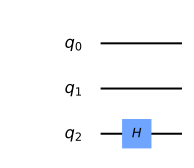

In [3]:
qc.h(2)
qc.draw()

次に、qubit 1の状態が$|1\rangle$の場合、これを1/4回転させます：

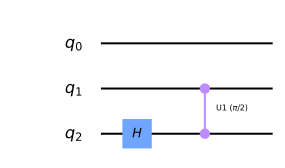

In [4]:
qc.cp(pi/2, 1, 2) # qubit 1 から qubit 2へのCROT 
qc.draw()

そして、最下位量子ビットqubit (0) が$|1\rangle$:の場合、さらに1/8回転：

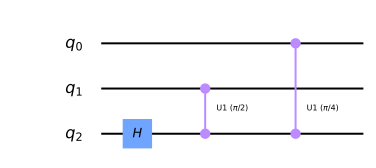

In [5]:
qc.cp(pi/4, 0, 2) # qubit 0から qubit 2へのCROT 
qc.draw()

qubit 2の演算が終わったので、qubits 0 と1に同じロジックを使用して、プロセスを繰り返します。

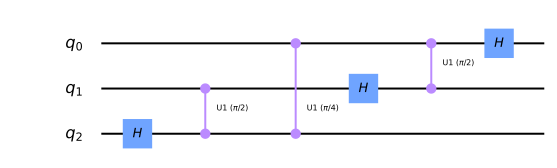

In [6]:
qc.h(1)
qc.cp(pi/2, 0, 1) # qubit 0からqubit 1へのCROT 
qc.h(0)
qc.draw()

最後に、QFTを完了するために、qubits 0と2をスワップする必要があります：

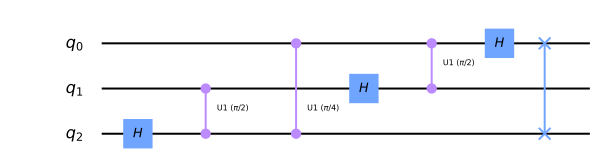

In [7]:
qc.swap(0,2)
qc.draw()

### 8.2 一般的なQFT関数 <a id="generalqft"></a>

QiskitでQFTの一般的な回路を作成します。 このような大規模な一般的な回路が作成できるところが、Qiskitが優れている点です。

量子ビットを上下逆にしてQFTを実装する回路を構築し、後でそれらをスワップする方が簡単です。 まず、量子ビットを正しく回転させる関数を作成します。 3量子ビットの例で行ったように、最上位の量子ビット（インデックスが最も高い量子ビット）を正しく回転させることから始めましょう。

In [8]:
def qft_rotations(circuit, n):
    if n == 0: # 回路が空の場合は関数を終了します
        return circuit
    n -= 1 # インデックスは0から始める
    circuit.h(n) # Hゲートを最上位量子ビットに適用する
    for qubit in range(n):
        # 量子ビットごとに、Indexが小さい方が
        # 角度の小さい制御回転を実行
        circuit.cp(pi/2**(n-qubit), qubit, n)

これがどのように見えるか見てみましょう：

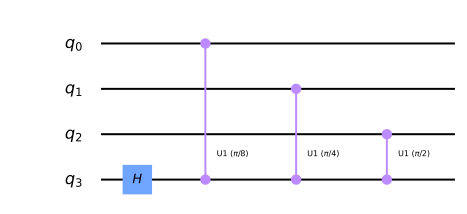

In [9]:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

以下のウィジェットを使用して、この回路が量子ビットの数に応じてどのようにスケーリングするかを確認できます。

In [10]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02W\x00\x00\x01\x08\x08\x06\x00\x00\x00r\x0b\xd1;\x…

すばらしいです！ これは、QFTの最初の部分です。最上位の量子ビットを正しく回転できたので、2番目に上位の量子ビットを正しく回転させます。 次に、3番目に上位のビットを処理させます。ところで、このためのコードをたくさん書く必要があるでしょうか？次の `qft_rotations()`関数の最後に、次の`n-1` 量子ビットでプロセスを繰り返すコードがあります。

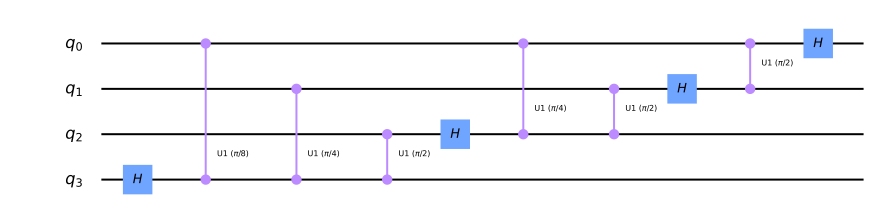

In [11]:
def qft_rotations(circuit, n):
    """回路の最初のn量子ビットでqftを実行します（スワップなしで）"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # この関数の最後で、次の量子ビットで同じ関数を再度呼び出します
    # （関数の前の方ですでにnを1つ減らしています）。
    qft_rotations(circuit, n)

# どうみえるか見てみましょう
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()

簡単でしたね！ 別の関数内で関数を使用することを「再帰」と呼びます。 コードを大幅に簡略化できます。 以下のウィジェットを使用して、これがどのようにスケーリングするかを再度確認できます。

In [12]:
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04u\x00\x00\x01\x08\x08\x06\x00\x00\x00\xd1\x16\xc8…

最後に、QFTの定義に一致させるために、QFT関数の最後にスワップを追加する必要があります。 これを最終的な関数`qft()`に付け加えます。

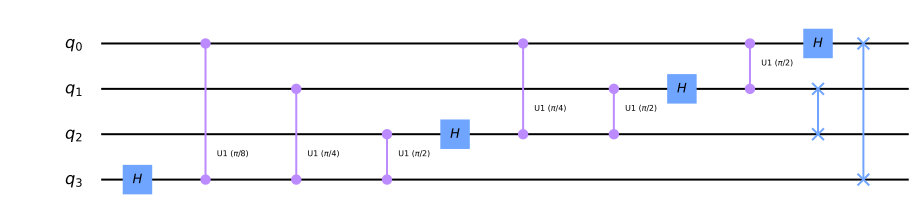

In [13]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """回路の最初のn量子ビットでQFT"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# どうみえるか見てみましょう
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

これが、量子フーリエ変換の一般化された回路です。 以下のウィジェットを使用して、これがどのようにスケーリングするかを再度確認できます。

In [14]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\xb1\x00\x00\x01\x08\x08\x06\x00\x00\x00\xa0BfN\x…

次に、この回路が正しく機能することをデモしてみましょう。そのためには、まず計算基底で数値をエンコードする必要があります。 2進数の5が `101`であることがわかります。

In [15]:
bin(5)

'0b101'

（`0b`は、これが2進数であることを示すための記号です）。 これを量子ビットにエンコードしましょう：

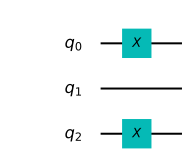

In [16]:
# 回路を作ります
qc = QuantumCircuit(3)

# 5の状態をエンコードします
qc.x(0)
qc.x(2)
qc.draw()  # 画像をフィットさせます

状態ベクトルシミュレーターを使用して量子ビットの状態をチェックしましょう：

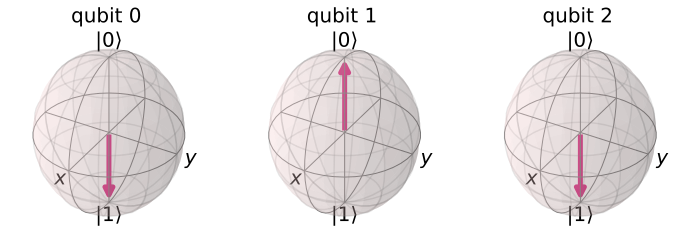

In [17]:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

QFT関数を使用して、量子ビットの最終状態を表示します。

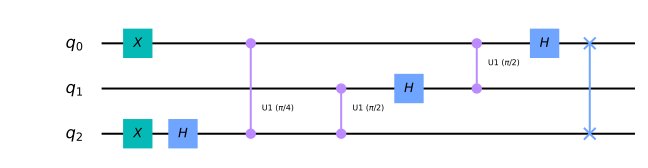

In [18]:
qft(qc,3)
qc.draw()

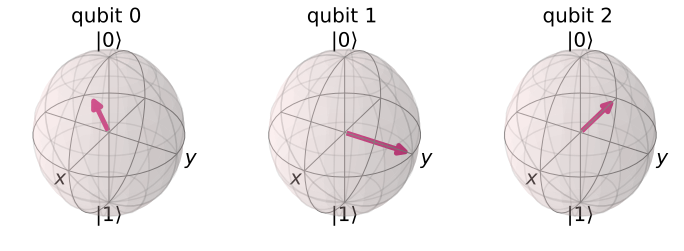

In [19]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

QFT関数が正しく機能していることがわかります。 状態$|\widetilde{0}\rangle = |{+}{+}{+}\rangle$と比較すると、Qubit 0は$\tfrac{5}{8}$回転、Qubit 1は$\tfrac{10}{8}$回転（１周の$\tfrac{1}{4}$に相当）、そしてqubit 2は$\tfrac{20}{8}$ 回転（１周の$\tfrac{1}{2}$ に相当）しています。 


### 8.3 実量子デバイスでのQFTの実行<a id="implementationdev"></a>

8.2章の後に、実デバイスで回路を実行しようとすると、すべての量子ビットが$|0\rangle$と $|1\rangle$の等しい重ね合わせにあるため、結果は完全にランダムになってしまいます。 実際のハードウェアで動作するQFTをデモして結果を調べたい場合は、代わりに8.2章の最後の状態$|\widetilde{5}\rangle$を先に作成し、QFTを逆に実行することで、出力が期待どおりに状態$|5\rangle$になることを確認します。 

まず、QiskitでQFT演算を逆にしましょう。

In [20]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # まず、正しいサイズのQFT回路を作成します。
    qft_circ = qft(QuantumCircuit(n), n)
    # 次に、この回路の逆をとります
    invqft_circ = qft_circ.inverse()
    # そして、それを既存の回路の最初のn量子ビットに追加します。
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() で個々のゲートを確認できます

では、量子ビットを$|\widetilde{5}\rangle$状態にします。

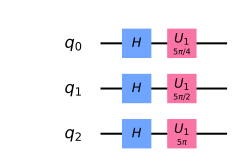

In [21]:
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)

qc.draw()

そして、これが実際にフーリエ状態$|\widetilde{5}\rangle$であることがわかります。

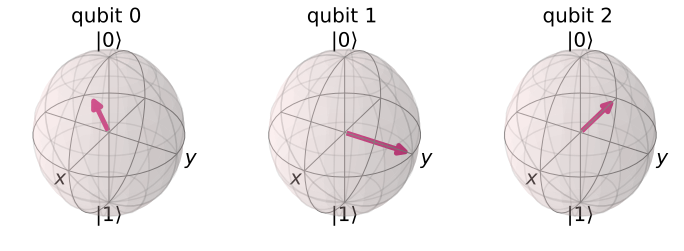

In [22]:
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

最後に、逆QFTを適用します。

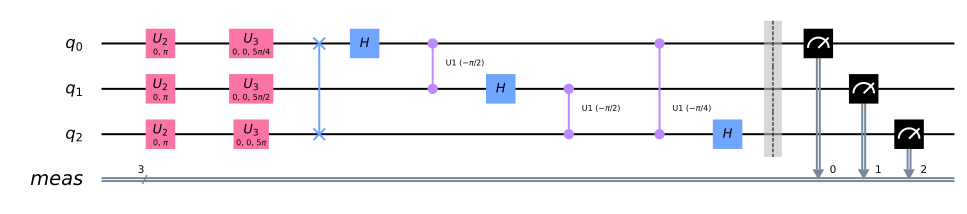

In [23]:
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

In [24]:
# 保存してあるIBMQアカウントをロードし、n量子ビット以下で最も混んでいないでバックエンドデバイスを取得します
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_london


In [25]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

Job Status: job has successfully run


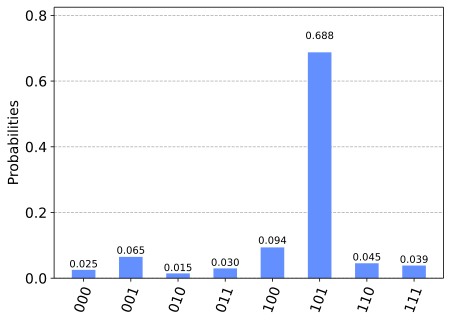

In [26]:
counts = job.result().get_counts()
plot_histogram(counts)

私たちは（うまくいけば）最も高い確率が101になることを確認できます。

## 9. 問題<a id="problems"></a>

1. QFTの[上記の実装](#implementationdev)は、$\text{QFT}^{\dagger}|\widetilde{5}\rangle = |101\rangle$であるフーリエ状態 $|\widetilde{5}\rangle$を準備することによってテストしました。 $\text{QFT}^{\dagger}|a\rangle = |100\rangle$となるような状態$|a\rangle$を見つけてみてください。
2.  $\text{QFT}^{\dagger}|b\rangle = |011\rangle$となるような状態$|b\rangle$を見つけてください。
3. 再帰なしでQFT関数を記述してください。 Qiskitのユニタリーシミュレーターを使用して、結果を確認してください。


## 10. 参考文献<a id="references"></a>

1. M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).

In [27]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}